![](https://raw.githubusercontent.com/quantumjot/btrack/main/docs/_static/btrack_logo.png)

# Example of using btrack to track cells in timelapse microscopy data

This notebook covers the following functionality:

* Load segmentation data and localize objects
* Load a table of localized objects 
* Run tracking algorithm
* Inspect the output
* Visualize the results in napari

In addition, we have an extensive tutorial of the cell tracking application as part of *napari*:  

https://napari.org/tutorials/tracking/cell_tracking.html

## Importing btrack and loading example datasets

In [71]:
import btrack

from btrack import datasets

We can automatically download some example data to play with:

In [2]:
CONFIG_FILE = datasets.cell_config()
SEGMENTATION_FILE = datasets.example_segmentation_file()
OBJECTS_FILE = datasets.example_track_objects_file()

## Finding objects to track

### Use case 1 - Objects from segmentation

These could be objects found using algorithms such as a UNet, *CellPose* or *StarDist*. We can use `scikit-image` to load the segmentation data, which returns a numpy array of dimensions (T, Y, X).

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import montage

In [10]:
segmentation = imread(SEGMENTATION_FILE)

In [5]:
segmentation.shape

(500, 1200, 1600)

### show the segmentation as a montage

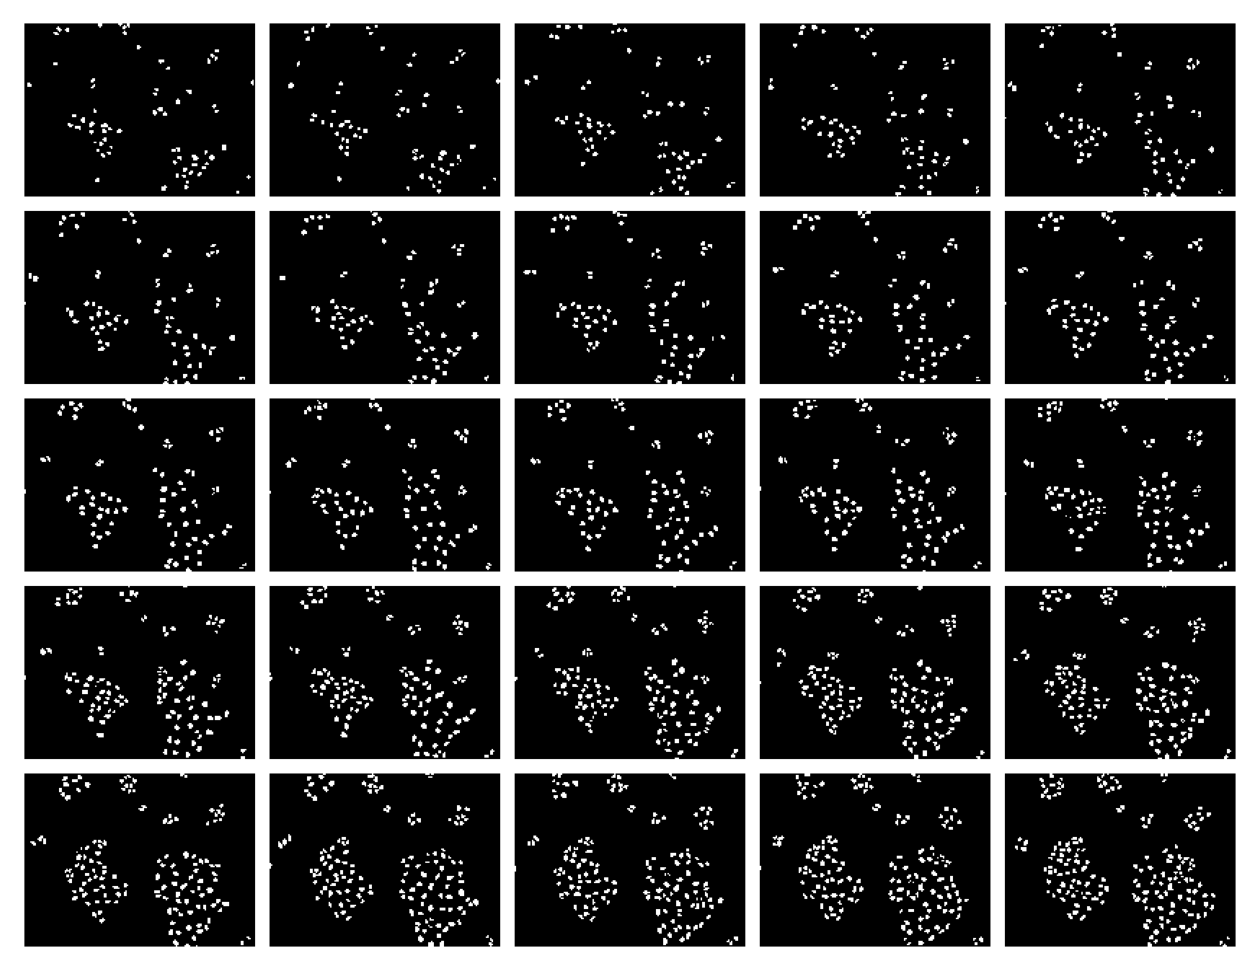

In [6]:
seq = montage(
    segmentation[::20, ::10, ::10], 
    grid_shape=(5, 5), 
    padding_width=10, 
    fill=255,
)

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(seq, cmap=plt.cm.gray)
ax.axis(False)
plt.show()

### localize the objects

Now we use a utility function to localise the objects in the segmentation. Note that we can also use scikit-image `regionprops` to calculate properties for each object, using the `properties` keyword:

In [7]:
FEATURES = [
    "area", 
    "major_axis_length", 
    "minor_axis_length", 
    "orientation", 
    "solidity"
]

objects = btrack.utils.segmentation_to_objects(
    segmentation, 
    properties=tuple(FEATURES), 
    num_workers=4,  # parallelise this
)

[INFO][2025/03/01 03:42:34 PM] Localizing objects from segmentation...
[INFO][2025/03/01 03:42:34 PM] Processing using 4 workers.
progress: 100%|██████████| 500/500 [00:24<00:00, 20.73it/s]
[INFO][2025/03/01 03:42:59 PM] Objects are of type: <class 'dict'>
[INFO][2025/03/01 03:42:59 PM] ...Found 52890 objects in 500 frames.


We can also inspect each returned object to determine it's properties:

In [8]:
objects[0]

,ID,x,y,z,t,dummy,states,label,area,major_axis_length,minor_axis_length,orientation,solidity
0,0,517.573657,9.07279,0.0,0,False,7,5,577,33.260603,22.856213,1.455708,0.968121


## Running the tracking

In [8]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure(CONFIG_FILE)
    tracker.max_search_radius = 50
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = FEATURES

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
    tracker.volume=((0, 1600), (0, 1200))

    # track them (in interactive mode)
    tracker.track(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # store the tracks
    tracks = tracker.tracks
    
    # store the configuration
    cfg = tracker.configuration
    
    # export the track data 
    # tracker.export("tracks.h5", obj_type="obj_type_1")
    

[INFO][2025/03/01 03:44:04 PM] Loaded btrack: /opt/anaconda3/lib/python3.12/site-packages/btrack/libs/libtracker.dylib
[INFO][2025/03/01 03:44:04 PM] Starting BayesianTracker session
[INFO][2025/03/01 03:44:04 PM] Loading configuration file: /Users/user/Library/Caches/btrack-examples/examples/cell_config.json
[INFO][2025/03/01 03:44:04 PM] Objects are of type: <class 'list'>
[INFO][2025/03/01 03:44:05 PM] Starting tracking... 
[INFO][2025/03/01 03:44:05 PM] Update using: ['MOTION', 'VISUAL']
[INFO][2025/03/01 03:44:05 PM] Tracking objects in frames 0 to 99 (of 500)...
[INFO][2025/03/01 03:44:05 PM]  - Timing (Bayesian updates: 0.47ms, Linking: 0.34ms)
[INFO][2025/03/01 03:44:05 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2025/03/01 03:44:05 PM]  - Stats (Active: 78, Lost: 48, Conflicts resolved: 114)
[INFO][2025/03/01 03:44:05 PM] Tracking objects in frames 100 to 199 (of 500)...
[INFO][2025/03/01 03:44:06 PM]  - Timing (Bayesian updates: 0.58ms, Linking: 0.40ms)
[INFO][

GLPK Integer Optimizer 5.0
1516 rows, 1361 columns, 2025 non-zeros
1361 integer variables, all of which are binary
Preprocessing...
758 rows, 1361 columns, 2025 non-zeros
1361 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 758
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
758 rows, 1361 columns, 2025 non-zeros
*     0: obj =   2.712542017e+03 inf =   0.000e+00 (265)
*   207: obj =   9.179170564e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   207: mip =     not found yet >=              -inf        (1; 0)
+   207: >>>>>   9.179170564e+02 >=   9.179170564e+02   0.0% (1; 0)
+   207: mip =   9.179170564e+02 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


[INFO][2025/03/01 03:44:10 PM] Completed optimization with 336 tracks
[INFO][2025/03/01 03:44:11 PM] Ending BayesianTracker session


## Inspecting the output

We can also inspect each returned track to determine it's properties:

In [11]:
cell = tracks[1]

In [12]:
cell

,ID,t,x,y,z,parent,root,state,generation,dummy,solidity,area,minor_axis_length,major_axis_length,orientation
0,2,0,657.399225,4.426357,0.0,2,2,5,0,False,0.973585,258.0,11.908765,28.650424,1.534682
1,2,1,657.715481,4.029289,0.0,2,2,5,0,False,0.983539,239.0,11.040913,28.759037,1.557410
2,2,2,656.904167,4.125000,0.0,2,2,5,0,False,0.979592,240.0,11.037060,28.651696,1.530523
3,2,3,656.217993,4.667820,0.0,2,2,5,0,False,0.989726,289.0,12.138052,31.094621,1.543631
4,2,4,653.219298,6.710526,0.0,2,2,5,0,False,0.966102,342.0,17.054772,26.502698,-1.478267
5,2,5,654.336420,7.256173,0.0,2,2,5,0,False,0.975904,324.0,18.407481,23.073315,1.537582
6,2,6,653.078014,6.971631,0.0,2,2,5,0,False,0.975779,282.0,18.031229,20.781504,1.287062
7,2,7,653.767790,6.632959,0.0,2,2,5,0,False,0.960432,267.0,17.685798,20.536610,1.248538
8,2,8,651.496124,6.116279,0.0,2,2,5,0,False,0.962687,258.0,16.412172,21.267710,1.426393
9,2,9,650.666667,8.757106,0.0,2,2,5,0,False,0.962687,387.0,21.986416,23.116262,-1.434154


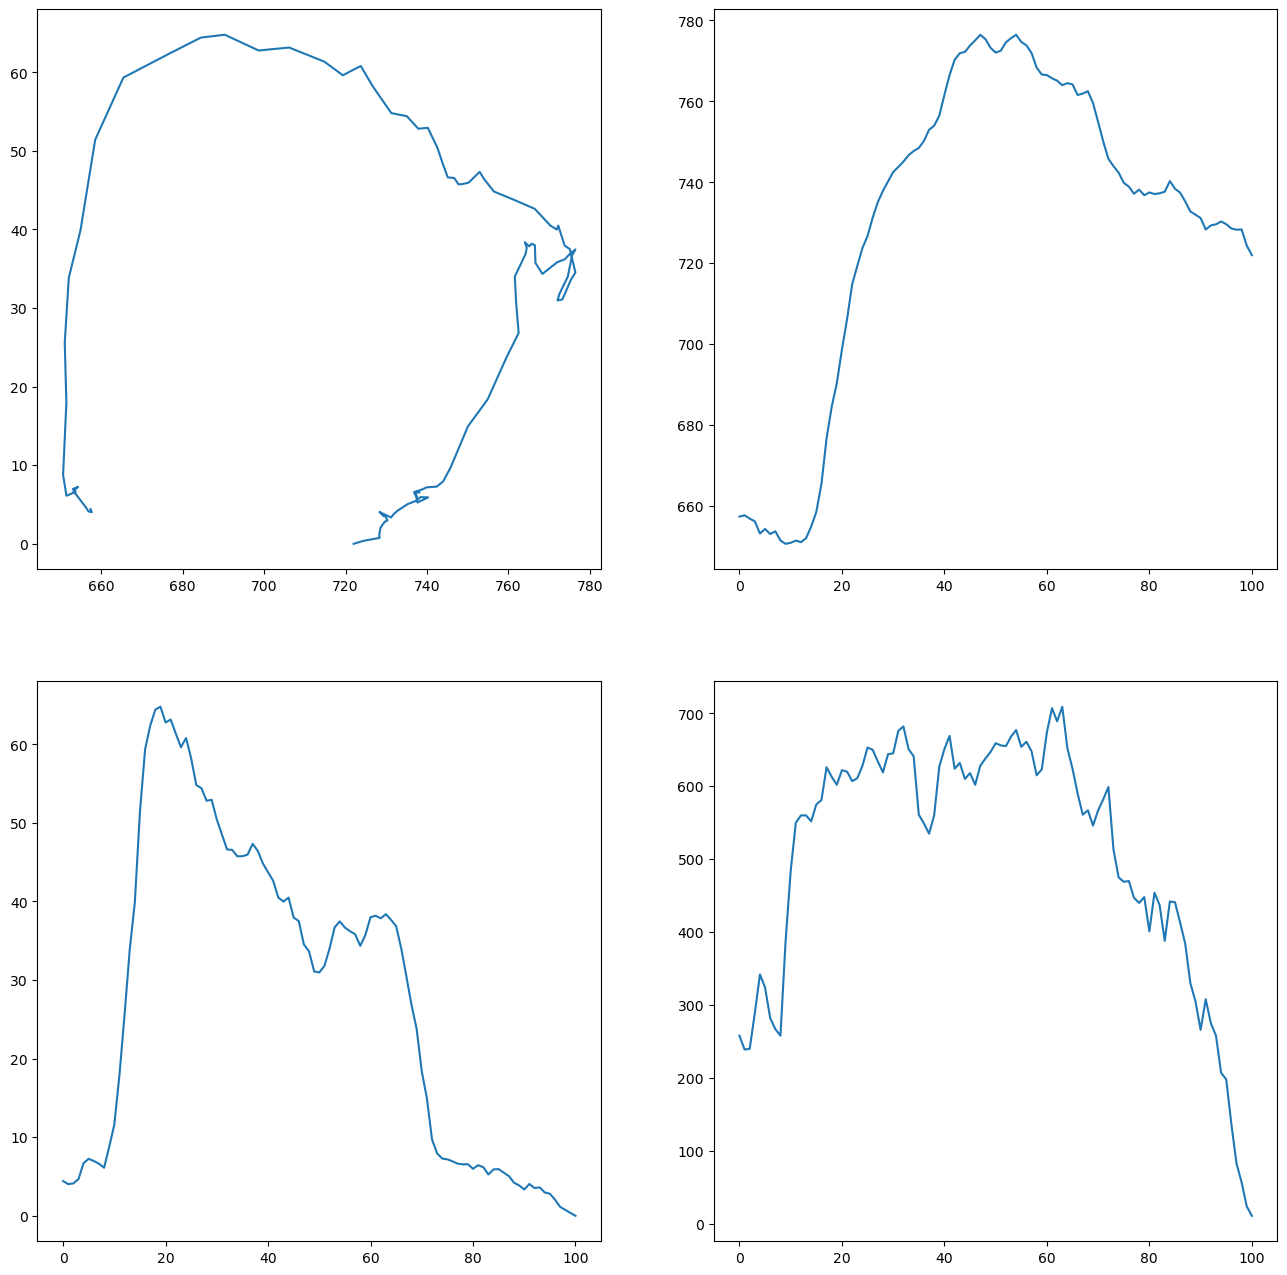

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
ax1.plot(cell.x, cell.y)
ax2.plot(cell.t, cell.x)
ax3.plot(cell.t, cell.y)
ax4.plot(cell.t, cell["area"])
plt.show()

## Visualising the data with napari

Finally, we an inspect the entire tracking output using *napari*:

In [9]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    segmentation, 
    name="Segmentation",
    opacity=0.2,
)

# the track data from the tracker
viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
    visible=True,
)

<Tracks layer 'Tracks' at 0x2e762a630>

In [7]:
import numpy as np
import btrack
from btrack import datasets
from nd2reader import ND2Reader
import napari


In [12]:
# Define the path to your ND2 file
ND2_FILE = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/nd2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"  # Change this to the actual path

with ND2Reader(ND2_FILE) as nd2_file:
    # Read first frame as a test (to avoid loading entire file at once)
    # first_frame = nd2_file[0]
    # print(f"Frame shape: {first_frame.shape}")
    image_data = np.array(nd2_file)

# Check dataset properties
print(f"ND2 dataset shape: {image_data.shape}")  # (Frames, Height, Width)
print(f"Number of frames: {len(image_data)}")



ND2 dataset shape: (37, 1040, 1392)
Number of frames: 37


In [21]:
from nd2_analyzer.analysis.segmentation import SegmentationModels
import numpy as np

import os

# Set the path to your U-Net model weights (change this to the actual path)
os.environ["UNET_WEIGHTS"] = "/Users/user/Desktop/Amby-Oliveira Lab/training_checkpoints/delta_2_20_02_24_600eps"

# Initialize the segmentation model (Cellpose, U-Net, or CellSAM)
seg_model = SegmentationModels()
MODEL_TYPE = SegmentationModels.UNET  # Change to CELLPOSE, CELLSAM if needed

# Ensure segmentation model receives correct image format
segmented_images = []
for frame in image_data:
    frame = np.squeeze(frame)  # Remove extra dimensions (e.g., channels)

    if frame.ndim == 3:  
        frame = frame[0]  # Take only the first channel if multi-channel

    frame = frame.astype(np.float32)  # Convert to float32

    # Pass frame as a list
    segmented = seg_model.segment_images([frame], mode=MODEL_TYPE)
    
    # Append only the first element (since we passed a list)
    segmented_images.append(segmented[0])

segmented_images = np.array(segmented_images)  # Convert to NumPy array
print(f"Final segmented images shape: {segmented_images.shape}")


Segmenting images using unet model


2025-03-01 19:44:39.046699: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-01 19:44:39.046863: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-01 19:44:39.046880: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-01 19:44:39.047675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-01 19:44:39.048362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-01 19:44:40.581837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Segmenting images using unet model
1/1 [==============================] - 1s 501ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 398ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 289ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 245ms/step
Segmenting images using unet model
1/1 [==============================] - 1s 546ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 311ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 238ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 346ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 303ms/step
Segmenting images using unet model
1/1 [==============================] - 0s 332ms/step
Segmenting images using unet model
1/1 [==============================

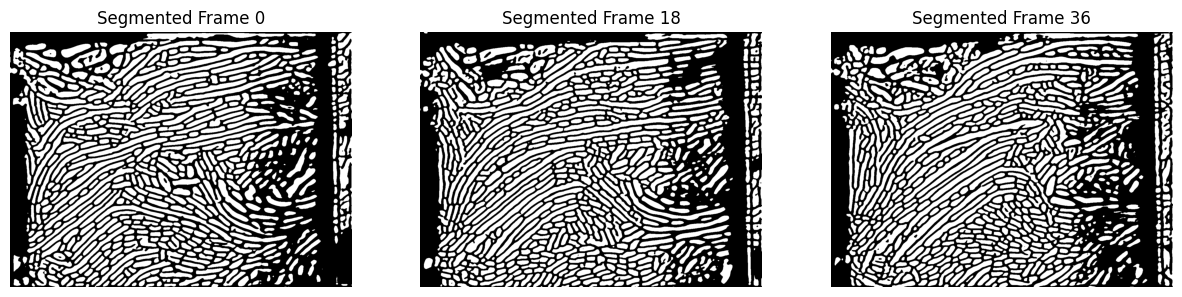

In [22]:
import matplotlib.pyplot as plt

# Select a few sample frames to display
frames_to_show = [0, len(segmented_images) // 2, len(segmented_images) - 1]  # First, middle, last

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, idx in zip(axes, frames_to_show):
    ax.imshow(segmented_images[idx], cmap='gray')
    ax.set_title(f"Segmented Frame {idx}")
    ax.axis("off")

plt.show()


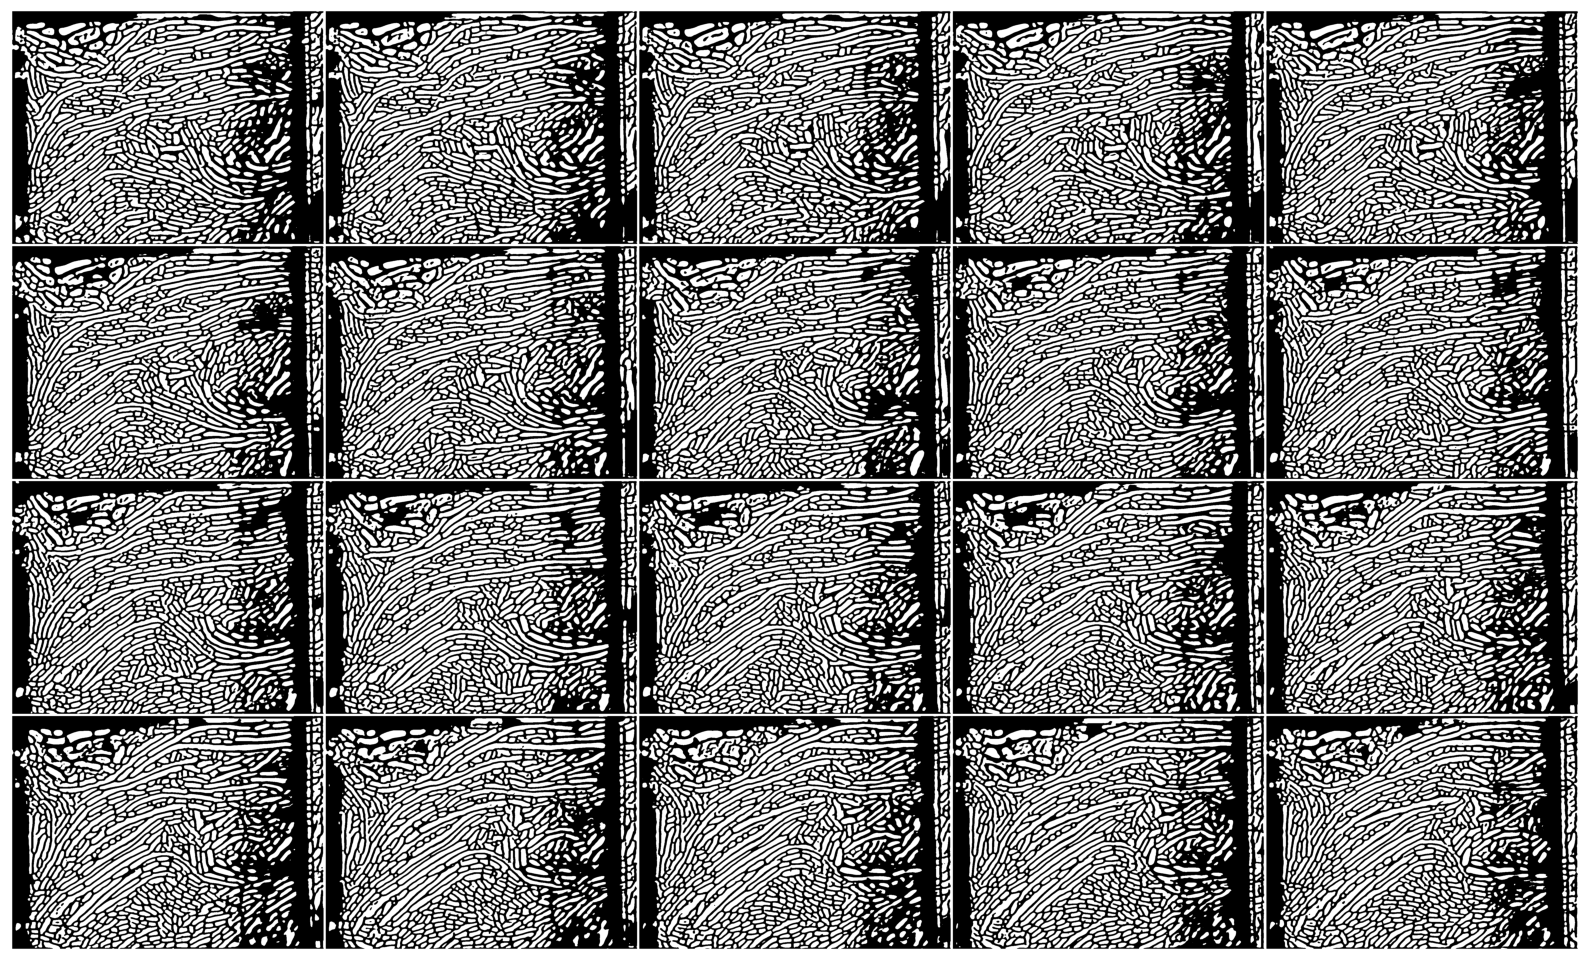

In [49]:
import matplotlib.pyplot as plt
from skimage.util import montage


# Create a montage of segmentation frames
def create_segmentation_montage(segmentation, grid_shape=(5, 5), step=1):
    """
    Create a montage of segmentation frames.
    
    Parameters:
    -----------
    segmentation : numpy.ndarray
        3D array of segmentation frames (time, height, width)
    grid_shape : tuple
        Number of rows and columns in the grid
    step : int
        Step size for selecting frames (to avoid showing every frame)
    
    Returns:
    --------
    numpy.ndarray
        Montage image
    """
    # Determine number of frames to show
    total_frames = min(grid_shape[0] * grid_shape[1], len(segmentation))
    
    # Select frames at regular intervals
    if len(segmentation) > total_frames:
        indices = np.linspace(0, len(segmentation)-1, total_frames, dtype=int)
    else:
        indices = range(0, len(segmentation), step)
        indices = indices[:total_frames]
    
    # Get selected frames
    selected_frames = segmentation[indices]
    
    # Convert to binary if not already
    binary_frames = (selected_frames > 0).astype(np.uint8) * 255
    
    # Create montage
    montage_image = montage(binary_frames, grid_shape=grid_shape, padding_width=10, fill=255)
    
    return montage_image

# Create and display the montage
grid_shape = (4, 5)  # Adjust rows and columns as needed
montage_img = create_segmentation_montage(segmented_images, grid_shape=grid_shape)

# Display the montage
plt.figure(figsize=(16, 16))
plt.imshow(montage_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('segmentation_montage.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Step 2: Define the features to extract (same as example)
FEATURES = [
    "area",
    "major_axis_length",
    "minor_axis_length",
    "orientation",
    "solidity"
]

# Step 3: Convert segmentation to btrack objects
objects = btrack.utils.segmentation_to_objects(
    segmented_images,
    properties=tuple(FEATURES),
    num_workers=4,
)

# Step 4: Configure and run the tracker
with btrack.BayesianTracker() as tracker:
    # Find the config file - you can use the example config or your own
    # If you want to use the example config:
    from btrack import datasets
    CONFIG_FILE = datasets.cell_config()
    
    # Or use your own config file path
    # CONFIG_FILE = '/path/to/your/btrack_config.json'
    
    # Configure the tracker
    tracker.configure(CONFIG_FILE)
    tracker.max_search_radius = 50  # Adjust based on cell movement
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = FEATURES
    
    # Append objects to tracker
    tracker.append(objects)
    
    # Set tracking volume based on your image dimensions
    h, w = segmented_images.shape[1:3]
    tracker.volume = ((0, w), (0, h))
    
    # Track them (with step_size for progress updates)
    tracker.track(step_size=100)
    
    # Optimize tracks (resolves track hypotheses)
    tracker.optimize()
    
    # Get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # Get raw tracks if needed
    tracks = tracker.tracks


[INFO][2025/03/01 08:46:59 PM] Localizing objects from segmentation...
INFO:btrack.io._localization:Localizing objects from segmentation...
[INFO][2025/03/01 08:46:59 PM] Processing using 4 workers.
INFO:btrack.io._localization:Processing using 4 workers.
progress: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]
[INFO][2025/03/01 08:47:06 PM] Objects are of type: <class 'dict'>
INFO:btrack.io.utils:Objects are of type: <class 'dict'>
[INFO][2025/03/01 08:47:06 PM] ...Found 24520 objects in 37 frames.
INFO:btrack.io._localization:...Found 24520 objects in 37 frames.
[INFO][2025/03/01 08:47:07 PM] Loaded btrack: /Applications/Oliveira Lab Projects/nd2-analyzer/.venv/lib/python3.10/site-packages/btrack/libs/libtracker.dylib
INFO:btrack.libwrapper:Loaded btrack: /Applications/Oliveira Lab Projects/nd2-analyzer/.venv/lib/python3.10/site-packages/btrack/libs/libtracker.dylib
[INFO][2025/03/01 08:47:07 PM] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INF

GLPK Integer Optimizer 5.0
15428 rows, 15730 columns, 24996 non-zeros
15730 integer variables, all of which are binary
Preprocessing...
7714 rows, 15730 columns, 24996 non-zeros
15730 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7714
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7714 rows, 15730 columns, 24996 non-zeros
*     0: obj =   3.573885044e+04 inf =   0.000e+00 (5667)
Perturbing LP to avoid stalling [548]...
Removing LP perturbation [4488]...
*  4488: obj =   1.519274292e+04 inf =   0.000e+00 (0) 5
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4488: mip =     not found yet >=              -inf        (1; 0)
+  4506: >>>>>   1.520184844e+04 >=   1.519664689e+04 < 0.1% (14; 0)
+  4613: >>>>>   1.520143255e+04 >=   1.520142187e+04 < 0.1% (7; 21)
+  4615: mi

[INFO][2025/03/01 08:47:35 PM] Completed optimization with 2822 tracks
INFO:btrack.core:Completed optimization with 2822 tracks
[INFO][2025/03/01 08:47:35 PM] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


In [ ]:
# Visualize with napari
import napari

viewer = napari.Viewer()

# Add segmentation image
viewer.add_image(
    segmented_images,
    name="Segmentation",
    opacity=0.2,
)
viewer.add_labels(segmented_images)
# Add tracks
viewer.add_tracks(
    data,
    properties=properties,
    graph=graph,
    name="Tracks",
    blending="translucent",
    visible=True,
)

napari.run()

[INFO][2025/03/01 11:48:34 PM] Loading configuration file: /Users/user/Library/Caches/btrack-examples/examples/cell_config.json
INFO:btrack.config:Loading configuration file: /Users/user/Library/Caches/btrack-examples/examples/cell_config.json
[INFO][2025/03/01 11:48:34 PM] Loading configuration file: /Users/user/Library/Caches/btrack-examples/examples/particle_config.json
INFO:btrack.config:Loading configuration file: /Users/user/Library/Caches/btrack-examples/examples/particle_config.json


In [41]:
import pandas as pd


# Convert tracks to a pandas DataFrame
def tracks_to_dataframe(tracks):
    data = []
    
    for track in tracks:
        # Get track data
        track_id = track.ID
        
        # Process each point in the track
        for i in range(len(track.t)):
            # Create a row for each timepoint
            row = {
                'ID': track_id,
                't': track.t[i],
                'x': track.x[i],
                'y': track.y[i],
                'z': 0.0,  # Most 2D tracking doesn't use z
                'parent': track.parent if hasattr(track, 'parent') else None,
                'root': track.root if hasattr(track, 'root') else None,
                'state': track.state if hasattr(track, 'state') else None,
                'generation': track.generation if hasattr(track, 'generation') else None
            }
            
            # Add any features the track might have
            if hasattr(track, 'features') and track.features is not None:
                for feature in FEATURES:
                    if i < len(track.features) and feature in track.features[i]:
                        row[feature] = track.features[i][feature]
            
            data.append(row)
    
    # Create DataFrame and sort by ID and t
    df = pd.DataFrame(data)
    df = df.sort_values(['ID', 't']).reset_index(drop=True)
    
    return df

# Create the DataFrame
tracking_df = tracks_to_dataframe(tracks)

# Display the table
print(tracking_df.head(30))

# Save to CSV (optional)
tracking_df.to_csv('tracking_results.csv', index=False)

    ID   t            x          y    z  parent  root  \
0    1   0  1116.492780   0.492780  0.0       1     1   
1    1   1  1117.745946   0.491892  0.0       1     1   
2    1   2  1119.985455   0.492727  0.0       1     1   
3    1   3  1119.500000   0.494545  0.0       1     1   
4    1   4  1121.994545   0.494545  0.0       1     1   
5    1   5  1119.992593   0.492593  0.0       1     1   
6    1   6  1120.713748   0.489642  0.0       1     1   
7    1   7  1120.224105   0.489642  0.0       1     1   
8    1   8  1119.959459   0.486486  0.0       1     1   
9    1   9  1120.877756   0.464930  0.0       1     1   
10   1  10  1119.718690   0.487476  0.0       1     1   
11   1  11  1121.730994   0.487329  0.0       1     1   
12   1  12  1122.218569   0.487427  0.0       1     1   
13   1  13  1125.562874   0.471058  0.0       1     1   
14   1  14  1127.441211   1.125075  0.0       1     1   
15   1  15  1103.252280  25.310030  0.0       1     1   
16   1  16  1084.122951   0.377

In [ ]:
# Print statistics about the tracks
track_lengths = [len(track.x) for track in tracks]
avg_length = sum(track_lengths) / len(track_lengths)
max_length = max(track_lengths)

print(f"Total tracks: {len(tracks)}")
print(f"Average track length: {avg_length:.2f} frames")
print(f"Longest track: {max_length} frames")

# Count tracks by length
short_tracks = sum(1 for length in track_lengths if length < 5)
medium_tracks = sum(1 for length in track_lengths if 5 <= length < 15)
long_tracks = sum(1 for length in track_lengths if length >= 15)

print(f"Short tracks (<5 frames): {short_tracks}")
print(f"Medium tracks (5-14 frames): {medium_tracks}")
print(f"Long tracks (≥15 frames): {long_tracks}")

# Analyze division events if present
division_events = 0
for track in tracks:
    if hasattr(track, 'children') and track.children:
        division_events += 1

print(f"Cell division events: {division_events}")

Total tracks: 2822
Average track length: 9.87 frames
Longest track: 37 frames
Short tracks (<5 frames): 1098
Medium tracks (5-14 frames): 1054
Long tracks (≥15 frames): 670
Cell division events: 323


Found 2176 root tracks
Found 2176 separate lineage trees


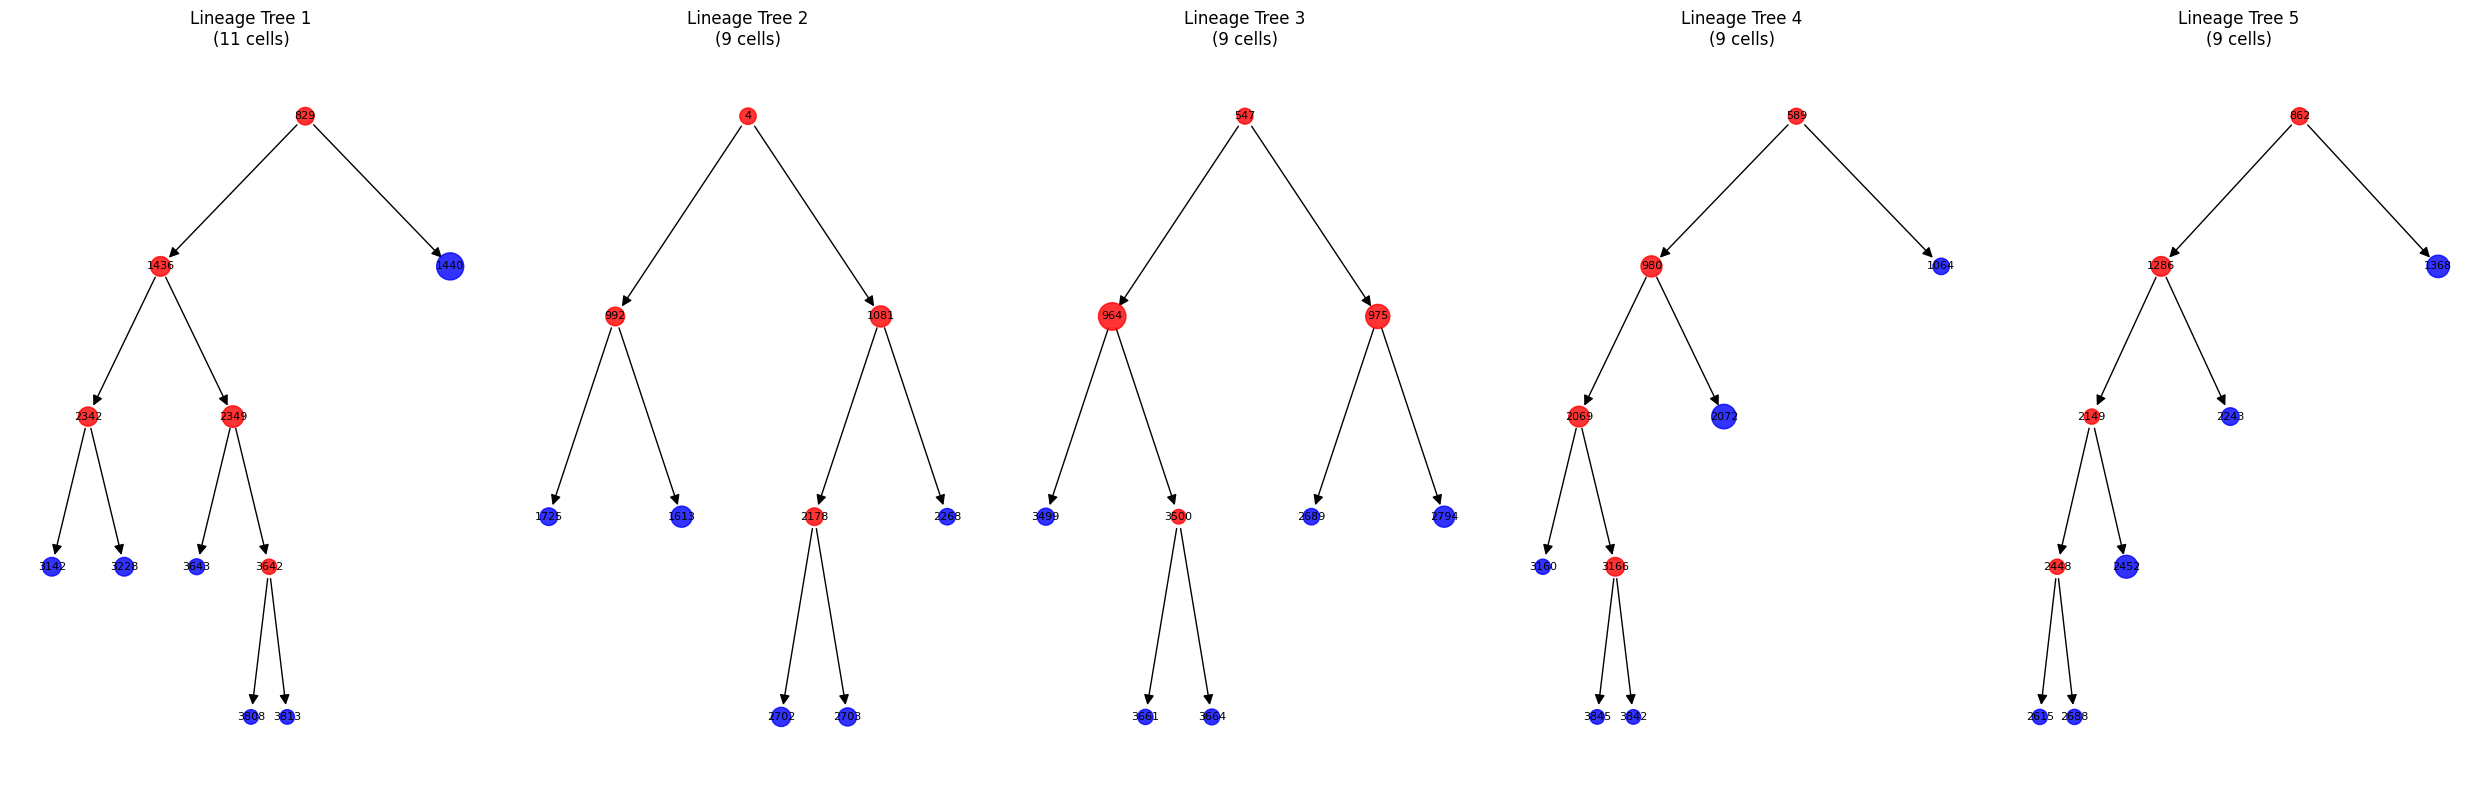

In [80]:


def create_lineage_tree(tracks):
    """
    Create a lineage tree visualization using NetworkX
    
    Parameters:
    -----------
    tracks : list
        List of track objects from btrack with lineage information
    """
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes for each track
    for track in tracks:
        track_id = track.ID
        
        # Get timing information
        if len(track.t) > 0:
            start_time = int(min(track.t))
            end_time = int(max(track.t))
            duration = end_time - start_time + 1
        else:
            start_time = 0
            end_time = 0
            duration = 0
            
        # Determine if this track divides
        has_children = hasattr(track, 'children') and track.children
        
        # Add node with attributes
        G.add_node(track_id, 
                  start_time=start_time,
                  end_time=end_time,
                  duration=duration,
                  divides=has_children)
    
    # Add edges for parent-child relationships
    for track in tracks:
        # If this track has children, add edges to them
        if hasattr(track, 'children') and track.children:
            for child_id in track.children:
                G.add_edge(track.ID, child_id)
    
    # Find all root nodes (tracks without parents)
    root_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
    print(f"Found {len(root_nodes)} root tracks")
    
    # Find connected components (separate lineage trees)
    connected_components = list(nx.weakly_connected_components(G))
    print(f"Found {len(connected_components)} separate lineage trees")
    
    # For visualization, let's focus on the largest connected components
    largest_components = sorted(connected_components, key=len, reverse=True)
    
    # Select components to visualize (top 5 or fewer)
    top_components = largest_components[:min(5, len(largest_components))]
    
    # Create a subplot for each top component
    fig, axes = plt.subplots(1, len(top_components), figsize=(5*len(top_components), 8))
    if len(top_components) == 1:
        axes = [axes]  # Ensure axes is a list
    
    for i, component in enumerate(top_components):
        # Create subgraph for this component
        subgraph = G.subgraph(component)
        
        # Determine the root of this component
        component_roots = [n for n in subgraph.nodes() if subgraph.in_degree(n) == 0]
        if not component_roots:
            print(f"Warning: Component {i} has no root nodes")
            continue
            
        # Create a hierarchical layout - root at top, flowing downward
        pos = {}
        
        # Use hierarchical layout
        try:
            # Try to use graphviz for layout if available
            pos = nx.nx_agraph.graphviz_layout(subgraph, prog='dot')
        except:
            # Fall back to a custom hierarchical layout
            pos = hierarchy_pos(subgraph, component_roots[0])
        
        # Draw the lineage tree
        ax = axes[i]
        
        # Draw nodes with size based on duration and color based on division
        node_sizes = [100 + subgraph.nodes[n]['duration'] * 10 for n in subgraph.nodes()]
        node_colors = ['red' if subgraph.nodes[n]['divides'] else 'blue' 
                      for n in subgraph.nodes()]
        
        nx.draw_networkx_nodes(subgraph, pos, 
                             node_size=node_sizes,
                             node_color=node_colors,
                             alpha=0.8,
                             ax=ax)
        
        # Draw edges
        nx.draw_networkx_edges(subgraph, pos,
                             edge_color='black',
                             arrows=True,
                             arrowsize=15,
                             ax=ax)
        
        # Draw labels
        nx.draw_networkx_labels(subgraph, pos,
                              font_size=8,
                              ax=ax)
        
        # Set title and turn off axis
        ax.set_title(f"Lineage Tree {i+1}\n({len(component)} cells)")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('lineage_trees.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return G

# Helper function for hierarchical layout
def hierarchy_pos(G, root, width=1., vert_gap=0.1, vert_loc=0, xcenter=0.5):
    """
    If the graph is a tree this will return the positions to plot it.
    G: the graph
    root: the root node
    width: horizontal space allocated for this branch
    vert_gap: gap between levels
    vert_loc: vertical location of root
    xcenter: horizontal location of root
    """
    def _hierarchy_pos(G, root, width=1., vert_gap=0.1, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if parent is not None:
            if root in children:
                children.remove(parent)
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, 
                                    vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                    parent=root, parsed=parsed)
        return pos
    
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

# Create the lineage tree visualization
lineage_graph = create_lineage_tree(tracks)

Sample track ID: 1
Sample track attributes: ['ID', 'LBEP', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_data', '_kalman', '_repr_html_', 'children', 'covar', 'dummy', 'fate', 'generation', 'in_frame', 'is_leaf', 'is_root', 'kalman', 'label', 'mu', 'parent', 'predicted', 'properties', 'refs', 'root', 'softmax', 'start', 'state', 'stop', 't', 'to_array', 'to_dict', 'trim', 'type', 'x', 'y', 'z']
Has children attribute: True
Has parent attribute: True
Division events found in tracks: 323
This should match your reported count: 323
Adding track ID: 1
Adding track ID: 2
Adding track ID: 3
Adding track ID: 4
Adding track ID: 5
Added edge: 4 -> 992
Added edge: 4 -> 1081
Ad

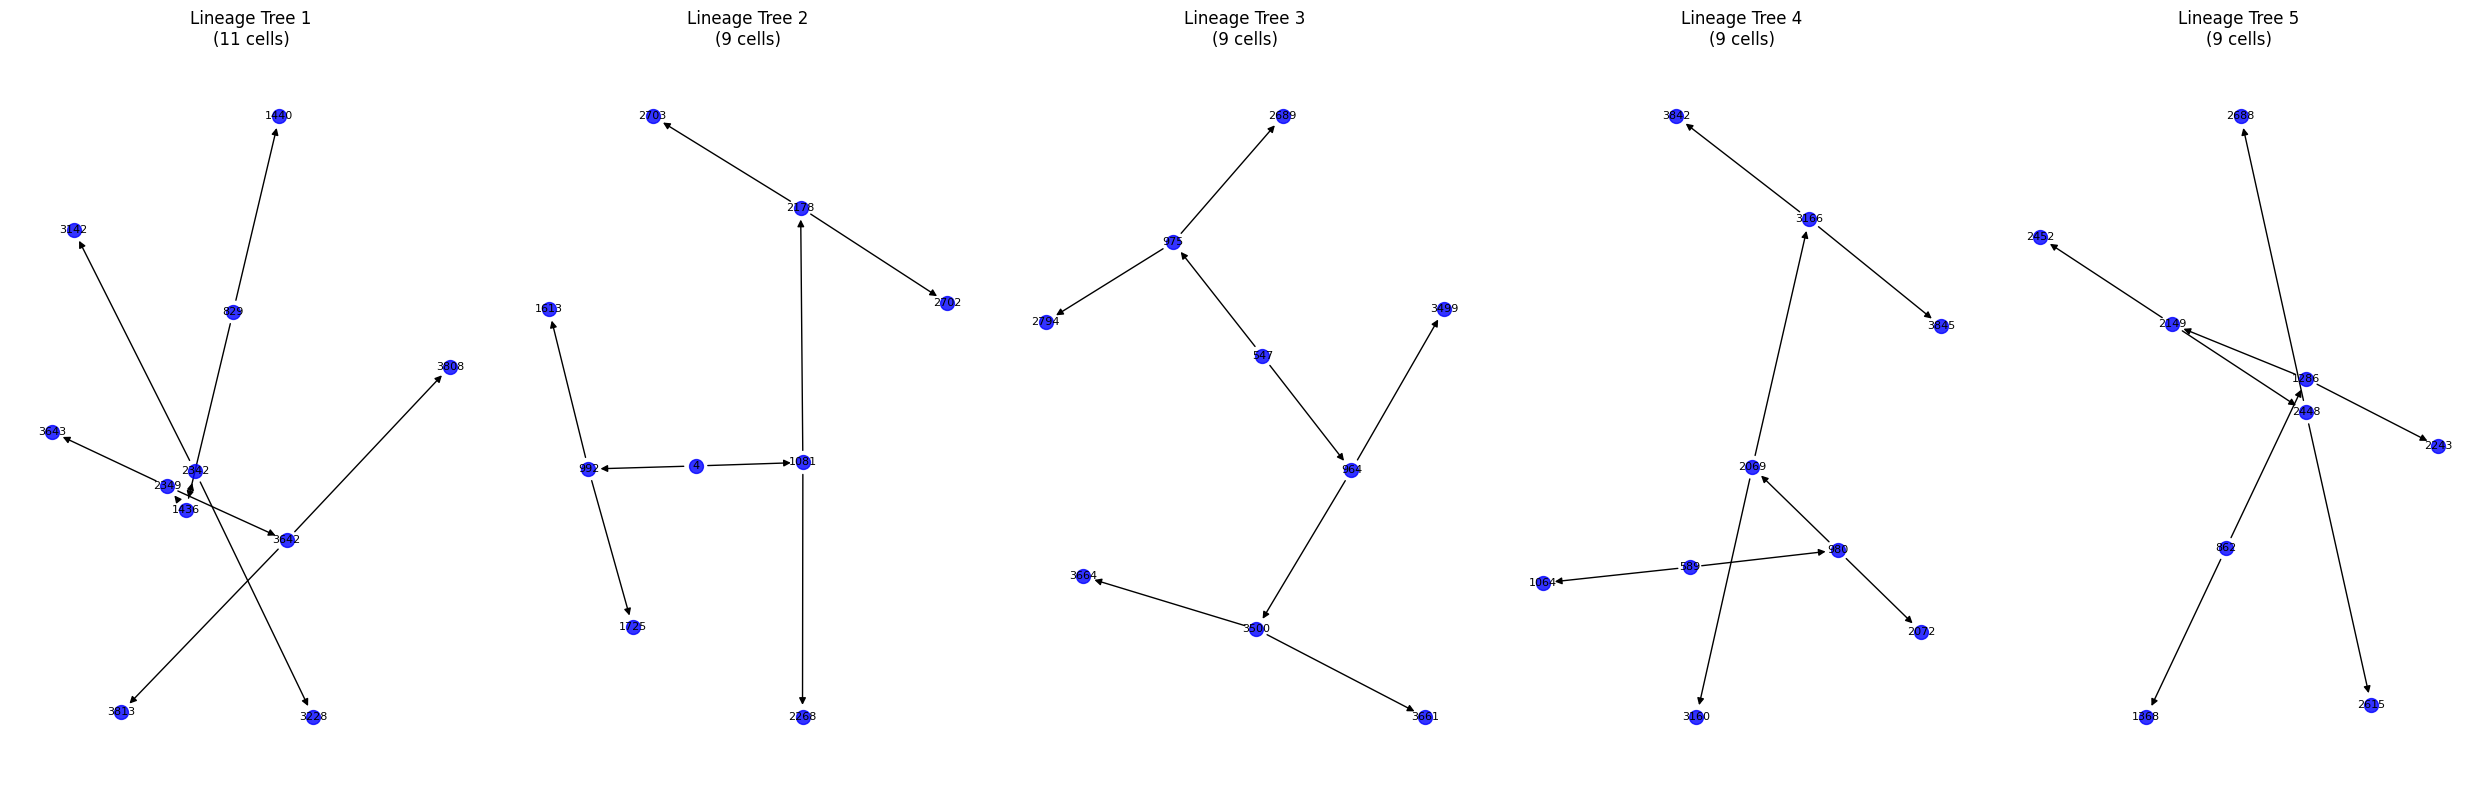

In [76]:
# First, let's examine one of your tracks to understand its structure
sample_track = tracks[0]
print("Sample track ID:", sample_track.ID)
print("Sample track attributes:", dir(sample_track))
print("Has children attribute:", hasattr(sample_track, 'children'))
print("Has parent attribute:", hasattr(sample_track, 'parent'))

# Check if we have division events as you reported
division_count = sum(1 for track in tracks if hasattr(track, 'children') and track.children)
print(f"Division events found in tracks: {division_count}")
print(f"This should match your reported count: 323")

# Now modify the lineage tree visualization to work with your data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def create_lineage_tree_from_tracks(tracks):
    """
    Create a lineage tree visualization specifically for your tracked cells
    """
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes for each track with IDs printed for verification
    for i, track in enumerate(tracks):
        track_id = track.ID
        if i < 5:  # Print first 5 for verification
            print(f"Adding track ID: {track_id}")
        
        # Add node
        G.add_node(track_id)
    
    # Add edges for parent-child relationships
    edges_added = 0
    for track in tracks:
        if hasattr(track, 'children') and track.children:
            children = track.children
            if not isinstance(children, list):
                children = [children]  # Convert to list if it's a single value
                
            for child_id in children:
                G.add_edge(track.ID, child_id)
                edges_added += 1
                if edges_added <= 5:  # Print first 5 for verification
                    print(f"Added edge: {track.ID} -> {child_id}")
    
    print(f"Added {edges_added} parent-child relationships")
    
    # Check if we have a valid graph for visualization
    if len(G.edges()) == 0:
        print("ERROR: No parent-child relationships found in the graph.")
        print("Cannot create lineage trees without relationships.")
        return G
    
    # Continue with visualization (rest of your code)
    # Find root nodes and connected components
    root_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
    print(f"Found {len(root_nodes)} root tracks")
    
    connected_components = list(nx.weakly_connected_components(G))
    print(f"Found {len(connected_components)} separate lineage trees")
    
    # Get the sizes of the largest components
    largest_components = sorted(connected_components, key=len, reverse=True)
    largest_sizes = [len(comp) for comp in largest_components[:5]]
    print(f"Largest lineage tree sizes: {largest_sizes}")
    
    # Visualize top components
    top_components = largest_components[:min(5, len(largest_components))]
    
    fig, axes = plt.subplots(1, len(top_components), figsize=(5*len(top_components), 8))
    if len(top_components) == 1:
        axes = [axes]  # Ensure axes is a list
    
    for i, component in enumerate(top_components):
        # Create subgraph for this component
        subgraph = G.subgraph(component)
        
        # Find roots in this component
        component_roots = [n for n in subgraph.nodes() if subgraph.in_degree(n) == 0]
        if not component_roots:
            print(f"Warning: Component {i} has no root nodes")
            continue
        
        # Create a layout
        try:
            # Try to use spring layout which doesn't require tree structure
            pos = nx.spring_layout(subgraph, seed=42)
            
            # Draw the graph
            ax = axes[i]
            nx.draw_networkx_nodes(subgraph, pos, 
                                node_size=100,
                                node_color='blue',
                                alpha=0.8,
                                ax=ax)
            
            nx.draw_networkx_edges(subgraph, pos,
                                edge_color='black',
                                arrows=True,
                                ax=ax)
            
            nx.draw_networkx_labels(subgraph, pos,
                                font_size=8,
                                ax=ax)
            
            ax.set_title(f"Lineage Tree {i+1}\n({len(component)} cells)")
            ax.axis('off')
        except Exception as e:
            print(f"Error visualizing component {i}: {e}")
    
    plt.tight_layout()
    plt.savefig('lineage_trees_from_tracking.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return G

# Create the lineage tree visualization from your data
lineage_graph = create_lineage_tree_from_tracks(tracks)